In [2]:
import os
import pandas as pd
import time
import datetime
import numpy as np
import sklearn
from sklearn.preprocessing import OneHotEncoder
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('2016_12.csv')
data.columns

D:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['ad_airing_id', 'ad_title', 'ad_type', 'viewing_start_time_utc',
       'viewing_start_time_est', 'viewing_start_time_local', 'tv_day',
       'airing_time_start_et', 'airing_time_end_et', 'brand_name',
       'industry_name', 'unique_pod', 'pod_duration', 'position_in_pod',
       'channel', 'channel_type', 'program', 'program_genre', 'program_type',
       'program_subtype', 'new_episode', 'tmsid', 'orig_airdate_est',
       'program_time_start', 'program_time_end', 'timeshifted', 'hh_id',
       'viewer_id', 'employment', 'age', 'gender', 'education', 'ethnicity',
       'party', 'hh_education', 'hh_employment', 'hh_ethnicity', 'hh_income',
       'hh_party', 'batch', 'ad_duration', 'program_block_duration',
       'active_seconds', 'visible_seconds', 'attention_seconds',
       'smile_seconds', 'active_to_duration_ratio', 'visible_to_active_ratio',
       'visible_to_duration_ratio', 'attention_to_visible_ratio',
       'attention_to_duration_ratio',
       'attention_to_vis

In [5]:
viewer_id = data['viewer_id']
len(pd.unique(viewer_id))
pd.unique(viewer_id)

array([ 724003,  586001, 2123005, ..., 2081032,  734001,  643022],
      dtype=int64)

In [6]:
ad_airing_id = data['ad_airing_id']
len(pd.unique(ad_airing_id))

830174

In [6]:
# active_ratio = data['active_to_duration_ratio']
# engagement level: attetion_to_duration_ratio
attention_ratio = data['attention_to_duration_ratio']

In [7]:
industry = data['industry_name']
len(pd.unique(industry))

170

In [8]:
timeString = data['viewing_start_time_utc'].tolist()
view_date = [] # y-m-d date format
time_unix = [] # uniform time format by seconds
for t in timeString:
    date_time_obj = datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f')
    v_d = date_time_obj.date()
    t_u = time.mktime(date_time_obj.timetuple())
    time_unix.append(t_u)
    view_date.append(v_d)

In [9]:
dictionary = {'viewer_id': viewer_id,'ads_id':ad_airing_id,'viewing_start_time_utc': timeString, 
              'time_unix': time_unix,'view_date':view_date,'attention_to_duration_ratio': attention_ratio, 'industry': industry}  
dt = pd.DataFrame(dictionary)

In [10]:
# plots for attention over time by sum and mean
plot_data = dt[['view_date','attention_to_duration_ratio']]
plot_sum = plot_data.groupby('view_date')['attention_to_duration_ratio'].sum()
plot_mean = plot_data.groupby('view_date')['attention_to_duration_ratio'].mean()

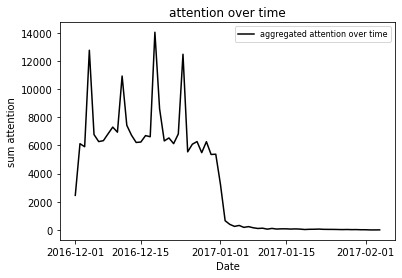

In [10]:
plt.plot(plot_sum.index,plot_sum.values, label="aggregated attention over time", color='k')
plt.ylabel("sum attention")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("attention over time")
plt.show()

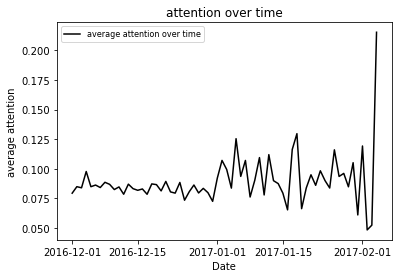

In [11]:
plt.plot(plot_mean.index,plot_mean.values, label="average attention over time", color='k')
plt.ylabel("average attention")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("attention over time")
plt.show()

In [ ]:
## Regression One
# Y = attention (engagement level) 
# X = previous 10-min windon attention (engagement level)
# control: Fixed Effect of viewers. Demeaned X and Y.

In [12]:
# data processing
# filter attention ratio = 0
dt = dt.loc[~(dt['attention_to_duration_ratio'] == 0)]
# sort viewer and time
dt = dt.sort_values(['viewer_id','viewing_start_time_utc'])
dt['prev_time_unix'] = dt.groupby('viewer_id')['time_unix'].shift()
dt['prev_attention'] = dt.groupby('viewer_id')['attention_to_duration_ratio'].shift()
gap = dt['time_unix'] - dt['prev_time_unix']
gap = gap.tolist() # time differences
prev_id = []
for i in gap:
    if i < 60*10: # ten minutes
        prev = 1
    else:
        prev = 0
    prev_id.append(prev)
dt['prev_id'] = prev_id # 0 and 1 indicator
dt['lag_attention'] =np.nan
dt.loc[dt['prev_id'] == 1, 'lag_attention'] = dt.loc[dt['prev_id'] == 1, 'prev_attention']
dt['prev_industry'] = dt.groupby('viewer_id')['industry'].shift()
dt = dt.dropna(subset=['lag_attention','industry','prev_industry'])

In [13]:
# viewer_id fixed effect
demean_dt = pd.DataFrame()
df = dt.groupby('viewer_id')

for name, group in df:
    m1 = group['attention_to_duration_ratio'].mean()
    m2 = group['lag_attention'].mean()
    demean_attention = group['attention_to_duration_ratio'] - m1
    demean_lag_attention = group['lag_attention'] - m2
    dic = {'demean_y':demean_attention,'demean_x':demean_lag_attention}
    demean = pd.DataFrame(dic)
    demean_dt = demean_dt.append(demean)
    
results = smf.ols('demean_y ~ demean_x', data=demean_dt).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               demean_y   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                 1.504e+05
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:39:09   Log-Likelihood:                 71976.
No. Observations:              407460   AIC:                        -1.439e+05
Df Residuals:                  407458   BIC:                        -1.439e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.935e-16      0.000   6.09e-13      1.0

In [14]:
## Regression Two
# Y = attention (engagement level) 
# X = categorical(industry) + categorical(prev_industry)
# previous 10-min window industry
# control: Fixed Effect of viewers. Demeaned X and Y.

In [15]:
# ads' industries fixed effect
demean_dt['industry'] = dt['industry']
demean_dt['prev_industry'] = dt['prev_industry']
# one hot encoded for industry
industry = dt['industry'].values.tolist()
uni_ind = pd.unique(dt['industry']).tolist()
uni_ind = [[d] for d in uni_ind]
drop_enc = OneHotEncoder(drop='first').fit(uni_ind) # drop the first col (avoid linearity)
industry = [[d] for d in industry]
industry_encod = drop_enc.transform(industry).toarray()
# one hot encoded for previous industry
prev_industry = dt['prev_industry'].values.tolist()
prev_industry = [[d] for d in prev_industry]
prev_industry_encod = drop_enc.transform(prev_industry).toarray()
# get the industry names
uni_ind = pd.unique(dt['industry']).tolist()
dt[uni_ind[1:]] = industry_encod
# get the previous industry names
pre_uni_ind = ['prev_'+d for d in uni_ind]
dt[pre_uni_ind[1:]] = prev_industry_encod

In [16]:
# demean of categorical industries
demean_encod_dt = pd.DataFrame()
df = dt.groupby('viewer_id')
ind = uni_ind[1:] + pre_uni_ind[1:]
for name,group in df:
    mat = group[ind].values
    mean_ind = np.mean(mat,axis=0)
    demean_mat = mat - mean_ind
    demean_df = pd.DataFrame(demean_mat, columns = ind)
    demean_encod_dt = demean_encod_dt.append(demean_df)

demean_y = pd.DataFrame()
for name, group in df:
    m1 = group['attention_to_duration_ratio'].mean()
    demean_attention = group['attention_to_duration_ratio'] - m1
    dic = {'demean_y':demean_attention}
    demean = pd.DataFrame(dic)
    demean_y = demean_y.append(demean)

demean_encod_dt['demean_y'] = demean_y['demean_y'].values

In [17]:
Y = demean_encod_dt['demean_y']
X = demean_encod_dt[ind]
model = sm.OLS(Y,X)
result2 = model.fit()
print(result2.summary())

                                 OLS Regression Results                                
Dep. Variable:               demean_y   R-squared (uncentered):                   0.011
Model:                            OLS   Adj. R-squared (uncentered):              0.011
Method:                 Least Squares   F-statistic:                              13.89
Date:                Sat, 20 Nov 2021   Prob (F-statistic):                        0.00
Time:                        12:57:56   Log-Likelihood:                          10286.
No. Observations:              407460   AIC:                                 -1.990e+04
Df Residuals:                  407124   BIC:                                 -1.623e+04
Df Model:                         336                                                  
Covariance Type:            nonrobust                                                  
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------

In [ ]:
# top/bottom 5 industries 
# top/bottom 5 previous industries

In [23]:
coef_ = result2.params
std = result2.bse

ind_coef = coef_[:168]
ind_std = std[:168]
prev_ind_coef = coef_[168:]
prev_ind_std = std[168:]

dict = {'coef':ind_coef,'std':ind_std,'l_cf': ind_coef - ind_std,'u_cf': ind_coef + ind_std}
ind_param = pd.DataFrame(dict)
prev_dict = {'coef':prev_ind_coef,'std':prev_ind_std,'l_cf': prev_ind_coef - prev_ind_std,'u_cf': prev_ind_coef + prev_ind_std}
prev_param = pd.DataFrame(prev_dict)

In [19]:
sorted_ind_param = ind_param.sort_values(by = ['coef'],ascending=False)
sorted_prev_param = prev_param.sort_values(by=['coef'],ascending=False)

select_ind = sorted_ind_param.iloc[:5]
select_ind = select_ind.append(sorted_ind_param.iloc[-5:])

In [20]:
select_prev_ind = sorted_prev_param.iloc[:5]
select_prev_ind = select_prev_ind.append(sorted_prev_param.iloc[-5:])

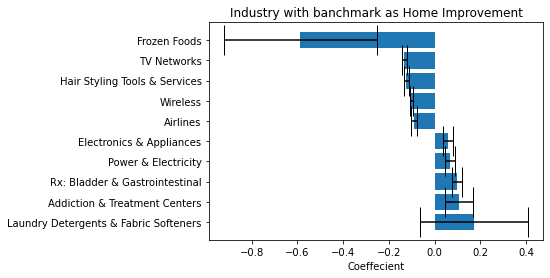

In [21]:
# plot industry
yvals = range(len(select_ind))
xvals = select_ind['coef'].values
x_std = select_ind['std'].values
plt.barh(yvals, xvals, xerr=x_std, capsize=15)
plt.yticks(range(len(select_ind)), select_ind.index)
plt.xlabel('Coeffecient')
plt.title('Industry with banchmark as Home Improvement')
plt.show()

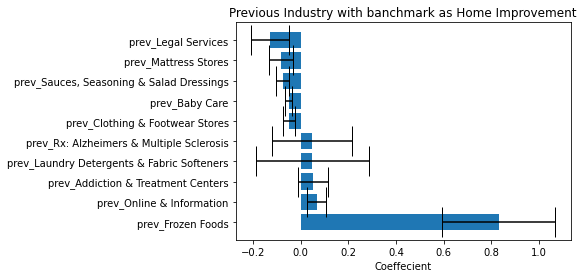

In [22]:
# plot previous industry
yvals = range(len(select_prev_ind))
xvals = select_prev_ind['coef'].values
x_std = select_prev_ind['std'].values
plt.barh(yvals, xvals, xerr=x_std, capsize=15)
plt.yticks(range(len(select_prev_ind)), select_prev_ind.index)
plt.xlabel('Coeffecient')
plt.title('Previous Industry with banchmark as Home Improvement')
plt.show()

In [ ]:
# Regression Three
# Y: coefficient of industry in their ranks
# X: coefficient of previous industry in their ranks

In [30]:
# rank correlation
from scipy.stats import spearmanr
#calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(ind_coef, prev_ind_coef)

#print Spearman rank correlation and p-value
print(rho)
print(p)

0.6452893030507035
3.677904999657976e-21
